## Deep Learning In Physics - Nanoscience group.

Julian Bernat

Ilija Gjerapić

Dorus Harmsen

Project: symmetry classification of xrd spectra, see [this paper](https://www.nature.com/articles/s41524-019-0196-x). Please also refer to the original [autoXRD github repo](https://github.com/PV-Lab/autoXRD)

To run this code it is necessary to have it in the same directory as autoXRD.py and have the datasets in the Datasets folder inside this directory.


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLP/DLP_autoXRD/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DLP/DLP_autoXRD


# Dependencies

In [ ]:
# Loads series of functions for preprocessing and data augmentation
from autoXRD import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

# Neural networks uses Keran with TF background
import keras as K
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling1D
from keras.models import load_model

import tensorflow as tf
from tensorflow import keras


# Loading data

THeoretical data:

In [ ]:
theor = pd.read_csv('Datasets/theor.csv', index_col=0)
theor = theor.iloc[1:,]
theor_arr=theor.values

# Normalize data for training
ntheor = normdata(theor_arr)

# Load labels for simulated data
label_theo = pd.read_csv('Datasets/label_theo.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

In [ ]:
ntheor.shape

(2125, 164)

In [ ]:
np.shape(label_theo)

(328,)

Experimental data:

In [ ]:
# Load experimental data as dataframe
exp_arr_new = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr_new = exp_arr_new.values

# Load experimental class labels
label_exp= pd.read_csv('Datasets/label_exp.csv', index_col=0).values
label_exp = label_exp.reshape([len(label_exp),])

# Load class enconding
space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Normalize experimental data
nexp = normdata(exp_arr_new)

# Define spectral range for data augmentation
exp_min = 0
exp_max = 1200
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))

In [ ]:
theor_max

1325

In [ ]:
ntheor.shape

(2125, 164)

# Data augmentation

Taking 50% of training and 50% of experimental as test, then using the remaining to augment

In [ ]:
#####################################################################
####    Labeling Theoretical and Experimental Data
#####################################################################
###  theoretical ###
n_naug_theo = len(ntheor[0])
croped_theo = np.zeros([theor_max - theor_min, n_naug_theo])
y_theo = np.zeros(n_naug_theo)
for i in range(n_naug_theo):
    croped_theo[:, i] = ntheor[theor_min:theor_max, i]
    y_theo[i] = space_group_enc.index(label_theo[2 * i]) # label is there for both x and y, thus need steps of 2

# preparing for testing
X_theo = np.transpose(croped_theo)
y_theo = y_theo

# experimental
exp_num =88

# Prepare experimental arrays for training and testing
X_exp = np.transpose(post_exp[:,0:exp_num])
y_exp = label_exp[0:exp_num]

#####################################################################
####    Splitting in half
#####################################################################

X_exp_test, X_exp_toAug, Y_exp_test, Y_exp_toAug = train_test_split(X_exp, y_exp, test_size=0.5, random_state=30)
X_theo_test, X_theo_toAug, Y_theo_test, Y_theo_toAug = train_test_split(X_theo, y_theo, test_size=0.5, random_state=30)


#####################################################################
####    Augmenting to have equal instances of each space group in Training
#####################################################################


# number of augmented data for each space group
aug_num = 400

# tmp_y_train = np.zeros([aug_num, len(np.unique(Y_exp_toAug))])
# tmp_x_train = np.zeros([aug_num, len(X_exp_toAug[0])])

tmp_exp_y_train = []
tmp_exp_x_train = []

tmp_theo_y_train = []
tmp_theo_x_train = []
for id in np.unique(Y_exp_toAug):
  # obtaining experimental spectra for each space group
  mask_exp = (Y_exp_toAug == id)
  X_exp_toAug_id = X_exp_toAug[mask_exp]
  Y_exp_toAug_id = Y_exp_toAug[mask_exp]

  # augmenting and appending data for experimental
  aug_x, aug_y = exp_augdata(X_exp_toAug_id.T, aug_num ,Y_exp_toAug_id.T)
  tmp_exp_x_train.append(aug_x.T)
  tmp_exp_y_train.append(aug_y.T)

  # obtaining theo spectra for each space group
  mask_theo = (Y_theo_toAug == id)
  X_theo_toAug_id = X_theo_toAug[mask_theo]
  Y_theo_toAug_id = Y_theo_toAug[mask_theo]

  # augmenting and storing data for theo
  # Use of exp_augdata(...) as data is already labelled
  aug_x, aug_y = exp_augdata(X_theo_toAug_id.T, aug_num ,Y_theo_toAug_id.T)
  tmp_theo_x_train.append(aug_x.T)
  tmp_theo_y_train.append(aug_y.T)

#####################################################################
####    Concatenating for separate experimental train and theo Train data
#####################################################################

exp_x_train = np.concatenate(tmp_exp_x_train, axis=0)
exp_y_train = np.concatenate(tmp_exp_y_train, axis=0)

theo_x_train = np.concatenate(tmp_theo_x_train, axis=0)
theo_y_train = np.concatenate(tmp_theo_y_train, axis=0)

In [ ]:
#####################################################################
####    Concatenating for Final Test and Train data
#####################################################################
x_train = np.concatenate((exp_x_train, theo_x_train), axis=0)
y_train = np.concatenate((exp_y_train, theo_y_train), axis=0)
X_test = np.concatenate((X_exp_test, X_theo_test), axis=0)
y_test = np.concatenate((Y_exp_test, Y_theo_test), axis=0)

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

data_train = {
    'Space group label': space_group_enc,
    'Counts in training dataset': counts
}

df_train = pd.DataFrame(data_train)

unique, counts = np.unique(y_test, return_counts=True)

data_test = {
    'Space group label': space_group_enc,
    'Counts in testing dataset': counts
}

df_test = pd.DataFrame(data_test)

Verifying sizes of train and test datasets

In [ ]:
df_train

,Space group label,Counts in training dataset
0,Fm-3m,800
1,I41mcm,800
2,P21a,800
3,P3m1,800
4,P61mmc,800
5,Pc,800
6,Pm-3m,800


In [ ]:
df_test

,Space group label,Counts in testing dataset
0,Fm-3m,37
1,I41mcm,16
2,P21a,12
3,P3m1,14
4,P61mmc,8
5,Pc,3
6,Pm-3m,36


# Visualization of data augmentation

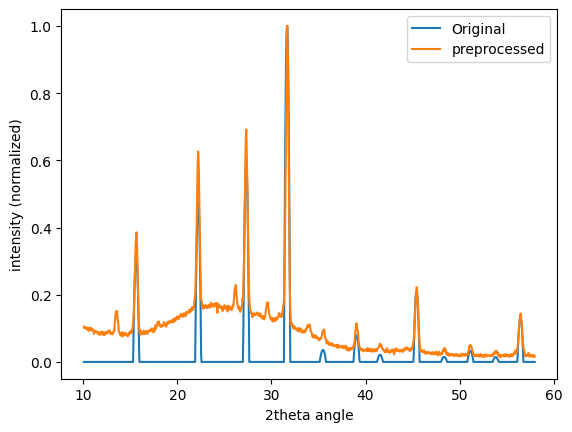

In [ ]:
rnd = 0#np.random.randint(0,100)
demo_t = post_exp[exp_min:exp_max,(rnd)]
demo_x = exp_arr_new[exp_min:exp_max,0]
plt.plot(demo_x,post_exp[:, 0],label='Original')
plt.plot(demo_x,nexp[exp_min:exp_max, 0], label='preprocessed')
plt.ylabel('intensity (normalized)')
plt.xlabel('2theta angle')
plt.legend(loc='upper right')
plt.show()

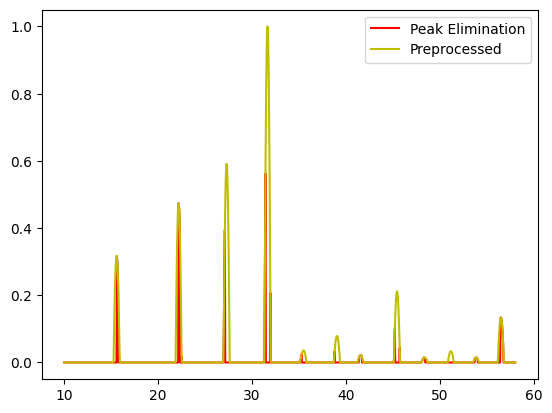

In [ ]:
#add in the first filter (peak elimination)
dum1= np.repeat(np.random.choice([0,0,1],300),len(demo_x)//300)
demo_1st = np.multiply(demo_t,dum1)
#plot
plt.plot(demo_x,demo_1st,label='Peak Elimination', color= 'r')
plt.plot(demo_x, demo_t, label='Preprocessed', color='y')
plt.legend(loc='upper right')
plt.show()

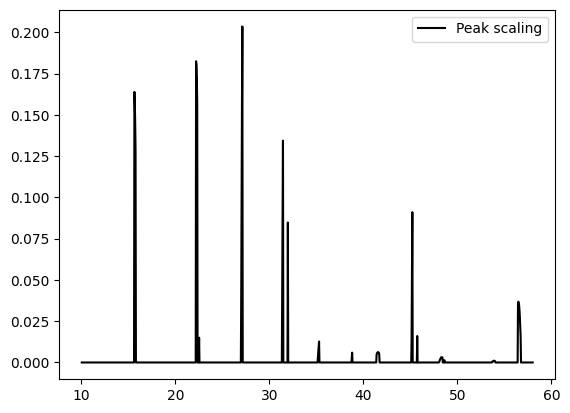

In [ ]:
dum2= np.repeat(np.random.rand(150,),len(demo_x)//150)
demo_2nd = np.multiply( demo_1st,dum2)
#plot
plt.plot(demo_x,demo_2nd,label='Peak scaling', color= 'k')
plt.legend(loc='upper right')
plt.show()

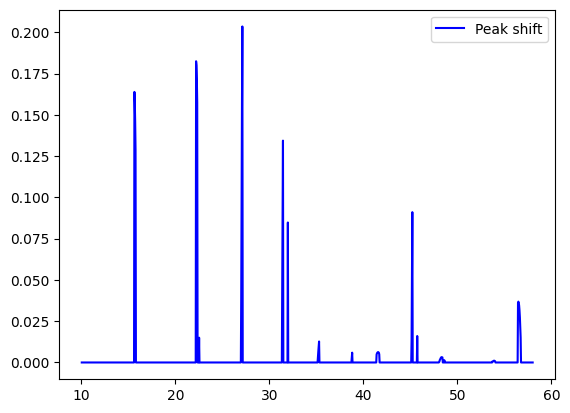

In [ ]:
cut = np.random.randint(-20*1,20)
#XRD spectrum shift to left
if cut>=0:
    demo_3rd = np.append(demo_2nd[cut:,],np.zeros([cut,]))
#XRD spectrum shift to right
else:
    demo_3rd = np.append(demo_2nd[0:len(demo_x)+cut,],np.zeros([cut*-1,]))
#plot
plt.plot(demo_x,demo_3rd,label='Peak shift', color= 'b')
plt.legend(loc='upper right')
plt.show()

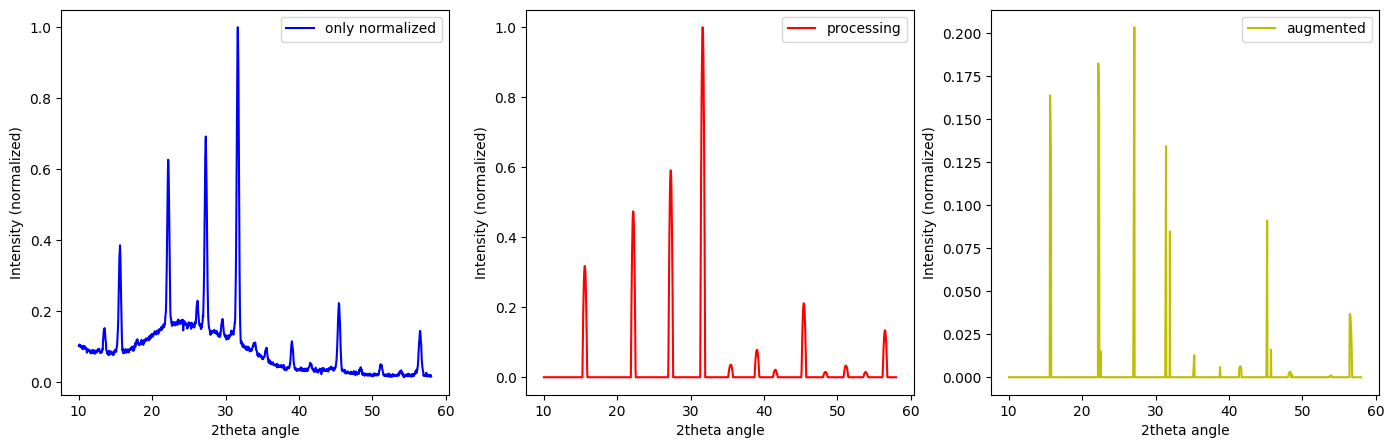

In [ ]:
#plotting all three spectra next to each other.
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(demo_x, nexp[exp_min:exp_max, 0], label='only normalized', color='b')
axs[1].plot(demo_x, post_exp[:, 0], label='processing', color='r')
axs[2].plot(demo_x, demo_3rd, label='augmented', color='y')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_ylabel('Intensity (normalized)')
axs[1].set_ylabel('Intensity (normalized)')
axs[2].set_ylabel('Intensity (normalized)')
axs[0].set_xlabel('2theta angle')
axs[1].set_xlabel('2theta angle')
axs[2].set_xlabel('2theta angle')
plt.show()
fig.tight_layout()

# Data preparation

In [ ]:
def data_prep():
    enc = OneHotEncoder()

    train_dim = x_train.reshape(x_train.shape[0],1200,1)
    train_y = y_train
    train_y_hot = enc.fit_transform(train_y.reshape(-1,1)).toarray()  # Convert to dense array

    # Define test data
    test_x = X_test.reshape(X_test.shape[0],1200,1)
    test_y = enc.fit_transform(y_test.reshape(-1,1)).toarray()

    if isinstance(train_y_hot, tf.sparse.SparseTensor):
        train_y_hot = tf.sparse.to_dense(train_y_hot)

    return train_dim, train_y_hot, test_x, test_y

train_x, train_y, test_x, test_y = data_prep()


# Defining different models

below you can write a function where we define specific models which can be loaded, evaluated and for which we can plot a confusion matrix

## CNN model

In [ ]:

# Define network structure
def a_cnn_model(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## Original CNN model with Categorical Cross-Entropy Loss

In [ ]:
# Define network structure
def a_cnn_model_cat_loss(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN model but with L1 regularization in each Conv1D layer

In [ ]:

# Define network structure
def a_cnn_model_reg(X_training, train_y_hot, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1),
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same',
                              activation='relu',kernal_regularizer=K.regularizers.l1(0.01)))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, train_y_hot, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## paper CNN but with more features for lower levels

In [ ]:
# Define network structure
def a_cnn_model_features(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(64, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(128, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN with more layers (2 more layers)
* added one Conv1D with 5 strides and one with 3 strides

In [ ]:
# Define network structure
def cnn_model_layers(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN model with batchnorm

I experimented with a CNN model which has batchnorm but I found that only 1 batchnorm layer works the best

In [ ]:

# Define network structure
def batchnorm_model(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam()

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN with batchnorm with a different optimizer

In [ ]:

# Define network structure
def batchnorm_model_sgd(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 2
    kernel_size = 10

    model = Sequential()

    model.add(K.layers.Conv1D(32, 8,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 3,strides=3, padding='same', activation='relu'))
    # model.add(K.layers.BatchNormalization())
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.SGD(learning_rate = 0.1, momentum=0.01)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## CNN big model

In [ ]:
def big_model(X_training, y_training, X_val, y_val):
    # Clear weights and networks state
    K.backend.clear_session()

    # Network Parameters
    BATCH_SIZE=128
    n_input = 1200 # MNIST data input (img shape: 28*28)
    n_classes = 7 # MNIST total classes (0-9 digits)
    filter_size = 10
    kernel_size = 2

    model = Sequential()

    model.add(K.layers.Conv1D(64, 8 ,strides=8, padding='same',input_shape=(1200,1), activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv1D(32, 5,strides=5, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(48, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Conv1D(64, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Dropout(0.1))
    model.add(K.layers.Conv1D(48, 3,strides=3, padding='same', activation='relu'))
    model.add(K.layers.Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(n_classes, activation='softmax'))

    #Define optimizer
    optimizer = K.optimizers.Adam(learning_rate = 0.001)

    # Compile model
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['categorical_accuracy'])
    hist = model.fit(X_training, y_training, batch_size=BATCH_SIZE, epochs=100,
                        verbose=1, validation_data=(X_val, y_val))
    return model, hist

## Decision tree

In [ ]:
import xgboost as xgb
def decision_tree(X_training, y_training, rounds):

    # Convert one-hot encoding to class indices
    #have to convert one hot back to indices
    y_train = np.argmax(y_training, axis=1)
    x_training = X_training.reshape(X_training.shape[0], -1)
    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(x_training, label=y_train)
    # dtest = xgb.DMatrix(X_test, label=y_test)

    # XGBoost parameters for multiclass classification
    params = {
        "objective": "multi:softmax",  # Multi-class classification
        "num_class": 7,  # Number of classes
        "eval_metric": "mlogloss",  # Multi-class log loss
    }

    # Train the model
    num_round = rounds  # Number of boosting rounds
    model = xgb.train(params, dtrain, num_round)

    return model

# Functions to evaluate the models

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def conf_matrix(model):
    prediction = model.predict(test_x)
    # For a classification task, convert predictions to class labels (if needed)
    prediction_ord=[np.argmax(element) for element in prediction]


    # If your true labels are one-hot encoded, you may need to convert them as well
    true_labels = [np.argmax(element) for element in test_y]

    cm = confusion_matrix(true_labels, prediction_ord, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()
    return None

## ROC Curves

Using ROC to evaluate multiple classes requires more consideration.
We have used the one-vs-rest (OVR) stategy, which is also refered to as the one-vs-all strategy. In this method, the ROC for each class is determined where a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

We consider both the micro-averaging and macro-averaging.

In micro-averaged OvR, the average metrics are computed as:
$$ TPR = \frac{\sum_CTP_C}{\sum_C(TP_C + FN_C)};$$
$$ FPR = \frac{\sum_CFP_C}{\sum_C(FP_C + TN_C)}.$$
Mainly, the contributions from all the classes are considered. Note, this is usefull for highly imbalanced classes as not all classses are treated equally prior to the calculation.

For macro-averaging, the metrics are computed independently for each class and then taking the average over them.
$$ TPR = \frac{1}{C}\sum_C\frac{TP_C}{TP_C + FN_C};$$
$$ FPR = \frac{1}{C}\sum_C\frac{FP_C}{FP_C + TN_C}.$$

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_OVR(model, test_x, test_y, X_test=None):
  """
  Determines and plots the ROC for the class vs rest classification.
  """
  prediction = model.predict(test_x)

  n_classes = len(np.unique(label_theo))

  # Compute ROC curve and AUC for each class
  fpr, tpr, roc_auc = dict(), dict(), dict()

  # ROC for each class
  for i in range(n_classes):  # 7 classes
      fpr[i], tpr[i], _ = roc_curve(test_y[:, i], prediction[:, i])
      roc_auc[i]= auc(fpr[i], tpr[i])


  # Micro-average ROC curve and AUC
  fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), prediction.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Compute macro-average ROC curve and AUC
  fpr_grid = np.linspace(0.0 , 1.0, 1000)

  # linear interpolate all ROC curves at the points
  mean_tpr = np.zeros_like(fpr_grid)
  for i in range(n_classes):
      mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

  # average it and then compute macros AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  #### Plotting all together ####

  plt.figure(figsize=(6, 6))

  # Plot ROC for each class
  colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
  for i, color in enumerate(colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label=f'{space_group_enc[i]} (AUC = {roc_auc[i]:.2f})')

  # Plot micro and macro average ROC curves
  plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
           label=f'Micro Avg (AUC = {roc_auc["micro"]:.2f})', lw=2)
  plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='gray',
           label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})', lw=2)

  # Plot diagonal line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--',
           label = "Chance level (AUC = 0.5)")

  # Labels and title
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-Class ROC Curve')
  plt.legend(loc='lower right')
  plt.show()


## Classification Report

In [ ]:
def class_report(model, test_x, test_y):
  """
  Outputs a summary of the classification for a model and test data.
  Includes the precision, recall, f1-score and support for each class.
  Along with the accuracy and macro average and weighted average.
  """
  prediction = model.predict(test_x)
  prediction_ord=[np.argmax(element) for element in prediction]


  # If your true labels are one-hot encoded, you may need to convert them as well
  true_labels = [np.argmax(element) for element in test_y]

  df  = classification_report(true_labels, prediction_ord, digits=4, output_dict=True)
  print(classification_report(true_labels, prediction_ord, digits=4))

  return df

## Plotting Accuracy for training and validation

In [ ]:
def plot_acc(hist):
  """
  Plots the accuracy for the training and validation data over epochs
  """
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
def eval_model(model, hist, test_x, test_y):
  """
  Combines all the functions to evaluate a model
  """
  model.summary()
  plot_acc(hist)
  conf_matrix(model)
  plot_roc_OVR(model, test_x, test_y)
  class_report(model, test_x, test_y)
  print(model.evaluate(test_x, test_y, return_dict = True))

# Training and evaluating different models

## Original CNN

In [ ]:
cnn_model, cnn_hist = a_cnn_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.1590 - loss: 0.6505 - val_categorical_accuracy: 0.1270 - val_loss: 0.4243
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.1441 - loss: 0.4176 - val_categorical_accuracy: 0.0476 - val_loss: 0.4123
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.1794 - loss: 0.4091 - val_categorical_accuracy: 0.1905 - val_loss: 0.4128
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.2423 - loss: 0.4054 - val_categorical_accuracy: 0.2460 - val_loss: 0.4016
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - categorical_accuracy: 0.4026 - loss: 0.3884 - val_categorical_accuracy: 0.1905 - val_loss: 0.3881
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.4331 - loss: 0.3487 - val_categorical_accuracy: 0.2540 - val_loss: 0.4213
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.4694 - loss: 0.3253 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

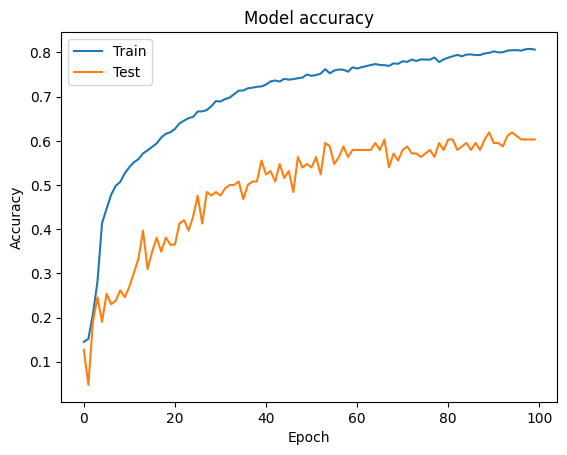

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


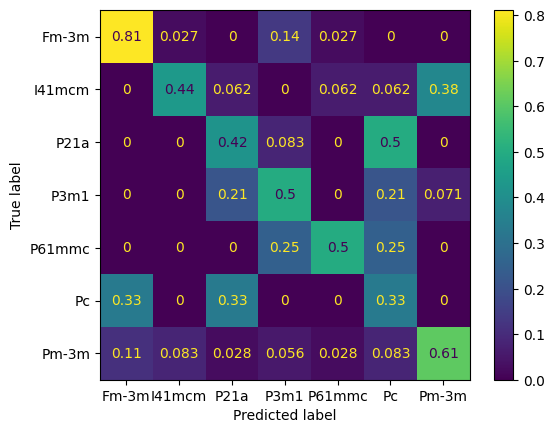

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


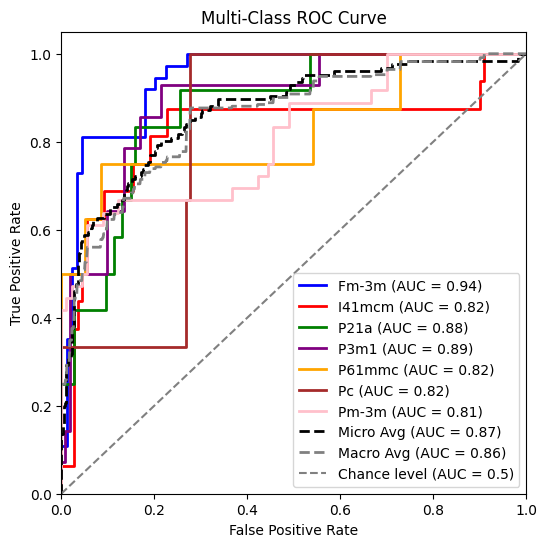

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0     0.8571    0.8108    0.8333        37
           1     0.6364    0.4375    0.5185        16
           2     0.4545    0.4167    0.4348        12
           3     0.4118    0.5000    0.4516        14
           4     0.5714    0.5000    0.5333         8
           5     0.0625    0.3333    0.1053         3
           6     0.7586    0.6111    0.6769        36

    accuracy                         0.6032       126
   macro avg     0.5361    0.5156    0.5077       126
weighted avg     0.6761    0.6032    0.6319       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.6131 - loss: 0.4779
{'categorical_accuracy': 0.60317462682724, 'loss': 0.4910335838794708}


In [ ]:
eval_model(cnn_model, cnn_hist, test_x, test_y)

## Original CNN with Categorical cross-entropy

In [ ]:
cnn_cat_model, cnn_cat_hist = a_cnn_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - categorical_accuracy: 0.1568 - loss: 0.6581 - val_categorical_accuracy: 0.1111 - val_loss: 0.4701
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.1667 - loss: 0.4184 - val_categorical_accuracy: 0.1429 - val_loss: 0.4122
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.2243 - loss: 0.4073 - val_categorical_accuracy: 0.1349 - val_loss: 0.4083
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.3287 - loss: 0.4006 - val_categorical_accuracy: 0.1587 - val_loss: 0.4016
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.3798 - loss: 0.3822 - val_categorical_accuracy: 0.1905 - val_loss: 0.3976
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.4449 - loss: 0.3442 - val_categorical_accuracy: 0.2063 - val_loss: 0.4132
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.5007 - loss: 0.3194 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

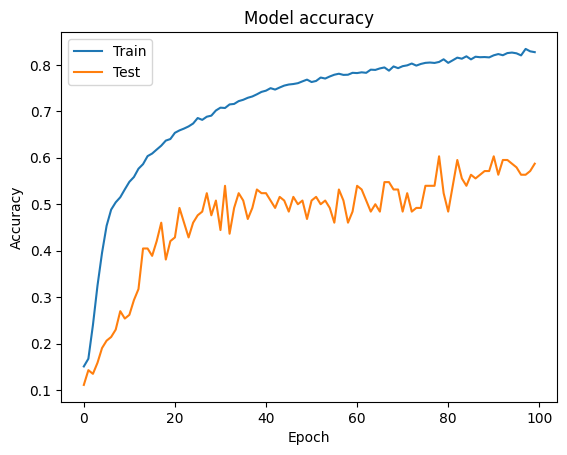

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


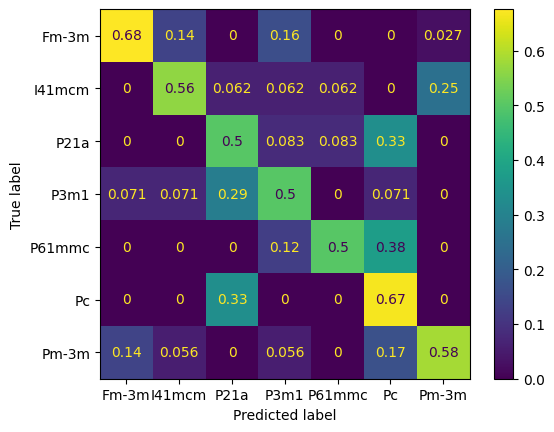

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


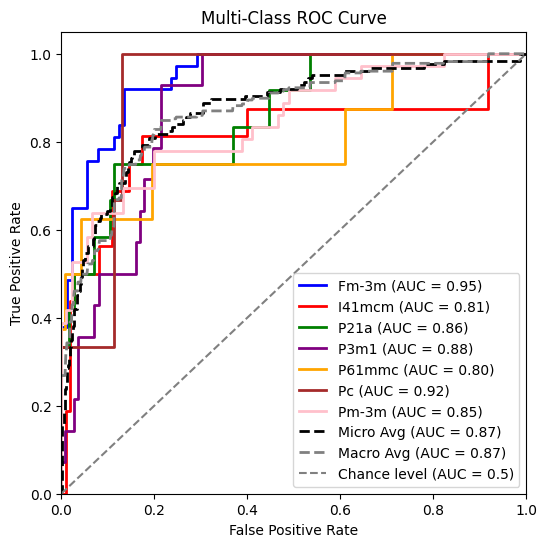

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0     0.8065    0.6757    0.7353        37
           1     0.5294    0.5625    0.5455        16
           2     0.5000    0.5000    0.5000        12
           3     0.3889    0.5000    0.4375        14
           4     0.6667    0.5000    0.5714         8
           5     0.1250    0.6667    0.2105         3
           6     0.8077    0.5833    0.6774        36

    accuracy                         0.5873       126
   macro avg     0.5463    0.5697    0.5254       126
weighted avg     0.6709    0.5873    0.6163       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.5964 - loss: 0.4967
{'categorical_accuracy': 0.5873016119003296, 'loss': 0.5084235668182373}


In [ ]:
eval_model(cnn_cat_model, cnn_cat_hist, test_x, test_y)

## CNN with regulariztion


In [ ]:
cnn_reg_model, cnn_reg_hist = a_cnn_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - categorical_accuracy: 0.1493 - loss: 0.6440 - val_categorical_accuracy: 0.0952 - val_loss: 0.4437
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - categorical_accuracy: 0.1601 - loss: 0.4155 - val_categorical_accuracy: 0.0635 - val_loss: 0.4111
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.1812 - loss: 0.4080 - val_categorical_accuracy: 0.1508 - val_loss: 0.4107
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.3333 - loss: 0.4028 - val_categorical_accuracy: 0.1587 - val_loss: 0.4080
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.3792 - loss: 0.3833 - val_categorical_accuracy: 0.1825 - val_loss: 0.4214
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.4350 - loss: 0.3457 - val_categorical_accuracy: 0.1905 - val_loss: 0.4491
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.4818 - loss: 0.3238 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,327 (102.84 KB)

 Trainable params: 8,775 (34.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,552 (68.57 KB)

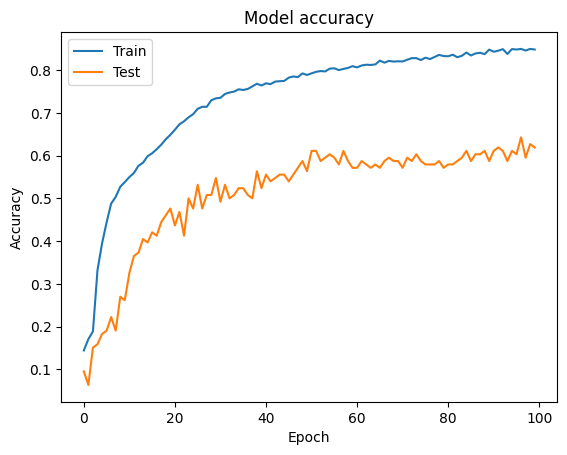

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


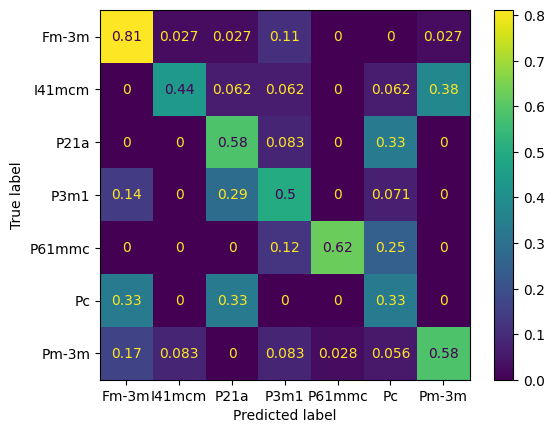

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


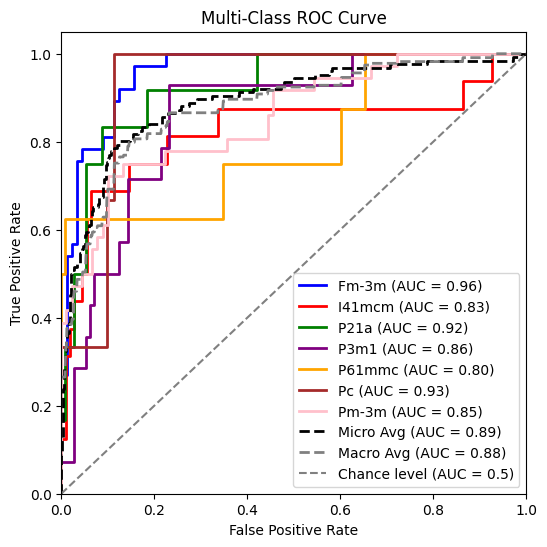

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0     0.7692    0.8108    0.7895        37
           1     0.6364    0.4375    0.5185        16
           2     0.5000    0.5833    0.5385        12
           3     0.4118    0.5000    0.4516        14
           4     0.8333    0.6250    0.7143         8
           5     0.0909    0.3333    0.1429         3
           6     0.7500    0.5833    0.6562        36

    accuracy                         0.6190       126
   macro avg     0.5702    0.5533    0.5445       126
weighted avg     0.6694    0.6190    0.6354       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6174 - loss: 0.5119
{'categorical_accuracy': 0.6190476417541504, 'loss': 0.5056823492050171}


In [ ]:
eval_model(cnn_reg_model, cnn_reg_hist, test_x, test_y)

## CNN with batchnorm

In [ ]:
cnn_batchnorm_model, batchnorm_hist = batchnorm_model(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - categorical_accuracy: 0.2610 - loss: 1.8886 - val_categorical_accuracy: 0.2302 - val_loss: 1.9097
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - categorical_accuracy: 0.4860 - loss: 1.4491 - val_categorical_accuracy: 0.0952 - val_loss: 2.0113
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.5562 - loss: 1.2176 - val_categorical_accuracy: 0.0952 - val_loss: 2.5029
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.6170 - loss: 1.0649 - val_categorical_accuracy: 0.0952 - val_loss: 3.2628
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.6683 - loss: 0.9413 - val_categorical_accuracy: 0.0952 - val_loss: 3.2444
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.6943 - loss: 0.8577 - val_categorical_accuracy: 0.0952 - val_loss: 3.4633
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.7165 - loss: 0.8080 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,583 (103.84 KB)

 Trainable params: 8,839 (34.53 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 17,680 (69.07 KB)

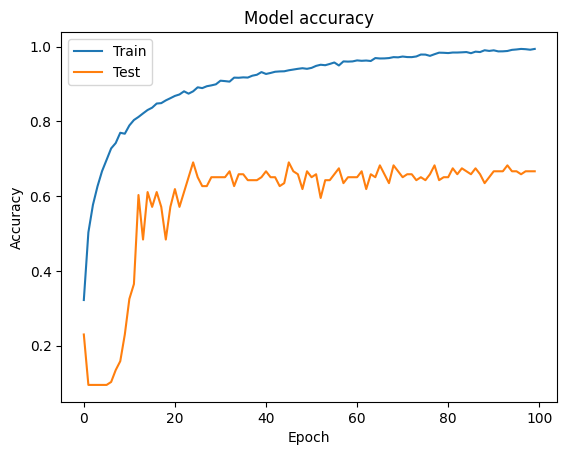

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


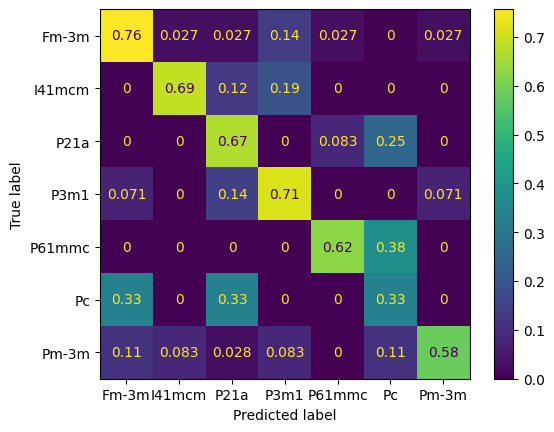

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


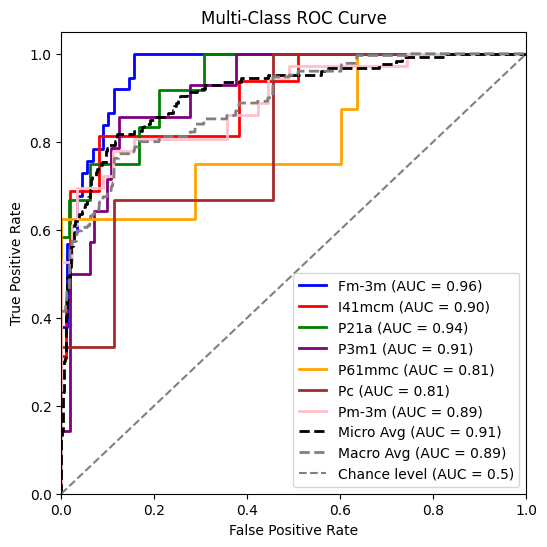

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0     0.8235    0.7568    0.7887        37
           1     0.7333    0.6875    0.7097        16
           2     0.5333    0.6667    0.5926        12
           3     0.4762    0.7143    0.5714        14
           4     0.7143    0.6250    0.6667         8
           5     0.0909    0.3333    0.1429         3
           6     0.9130    0.5833    0.7119        36

    accuracy                         0.6667       126
   macro avg     0.6121    0.6238    0.5977       126
weighted avg     0.7470    0.6667    0.6908       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.6740 - loss: 3.6335
{'categorical_accuracy': 0.6666666865348816, 'loss': 3.3485121726989746}


In [ ]:
eval_model(cnn_batchnorm_model, batchnorm_hist, test_x, test_y)

## CNN batchnorm with SGD

In [ ]:
sgd_cnn, sgd_hist = batchnorm_model_sgd(train_x, train_y, test_x, test_y)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - categorical_accuracy: 0.1496 - loss: 1.9480 - val_categorical_accuracy: 0.2937 - val_loss: 1.9385
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - categorical_accuracy: 0.3254 - loss: 1.8772 - val_categorical_accuracy: 0.1667 - val_loss: 1.9131
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - categorical_accuracy: 0.4069 - loss: 1.6317 - val_categorical_accuracy: 0.1587 - val_loss: 1.8718
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.4833 - loss: 1.4147 - val_categorical_accuracy: 0.0873 - val_loss: 2.0501
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - categorical_accuracy: 0.5285 - loss: 1.2937 - val_categorical_accuracy: 0.0238 - val_loss: 2.4861
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - categorical_accuracy: 0.5578 - loss: 1.2086 - val_categorical_accuracy: 0.0952 - val_loss: 2.8276
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - categorical_accuracy: 0.5729 - loss: 1.1527 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,744 (69.32 KB)

 Trainable params: 8,839 (34.53 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 8,841 (34.54 KB)

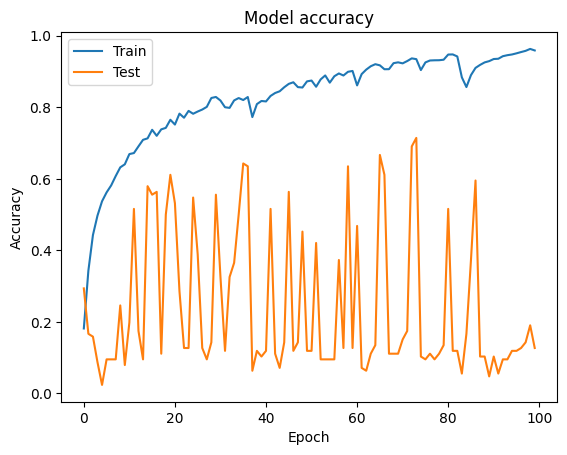

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


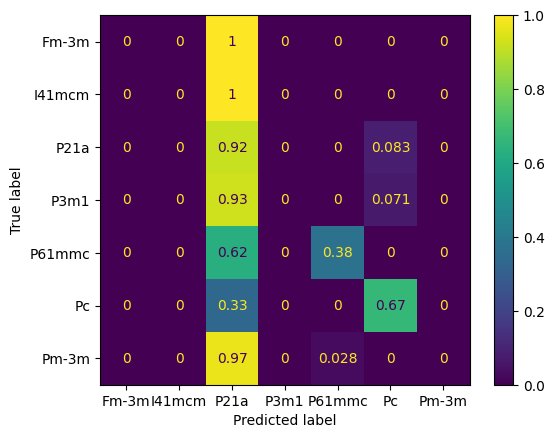

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


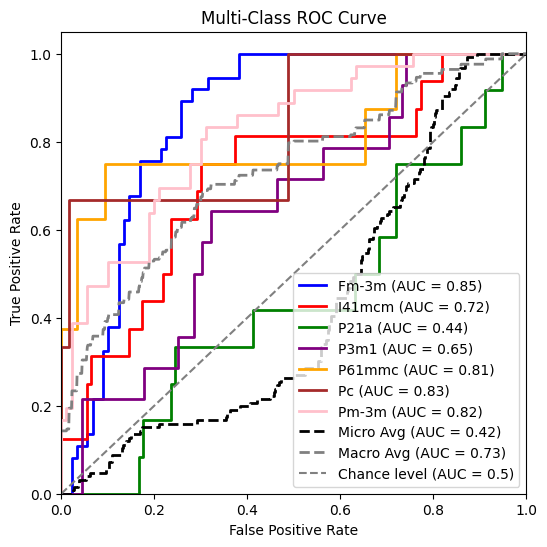

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        37
           1     0.0000    0.0000    0.0000        16
           2     0.0932    0.9167    0.1692        12
           3     0.0000    0.0000    0.0000        14
           4     0.7500    0.3750    0.5000         8
           5     0.5000    0.6667    0.5714         3
           6     0.0000    0.0000    0.0000        36

    accuracy                         0.1270       126
   macro avg     0.1919    0.2798    0.1772       126
weighted avg     0.0684    0.1270    0.0615       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.1050 - loss: 31.6292
{'categorical_accuracy': 0.1269841343164444, 'loss': 33.03776931762695}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
eval_model(sgd_cnn, sgd_hist, test_x, test_y)

## CNN with more conv1D layers

In [ ]:
layers_cnn, layers_hist = cnn_model_layers(train_x, train_y, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - categorical_accuracy: 0.1512 - loss: 0.6309 - val_categorical_accuracy: 0.0635 - val_loss: 0.4138
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.2169 - loss: 0.4081 - val_categorical_accuracy: 0.2540 - val_loss: 0.4003
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.5177 - loss: 0.3478 - val_categorical_accuracy: 0.2937 - val_loss: 0.3753
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.6773 - loss: 0.2216 - val_categorical_accuracy: 0.5714 - val_loss: 0.3352
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.7871 - loss: 0.1655 - val_categorical_accuracy: 0.6270 - val_loss: 0.3343
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8451 - loss: 0.1304 - val_categorical_accuracy: 0.6508 - val_loss: 0.3450
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - categorical_accuracy: 0.8801 - los

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 32)               │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 1, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,095 (199.59 KB)

 Trainable params: 17,031 (66.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,064 (133.07 KB)

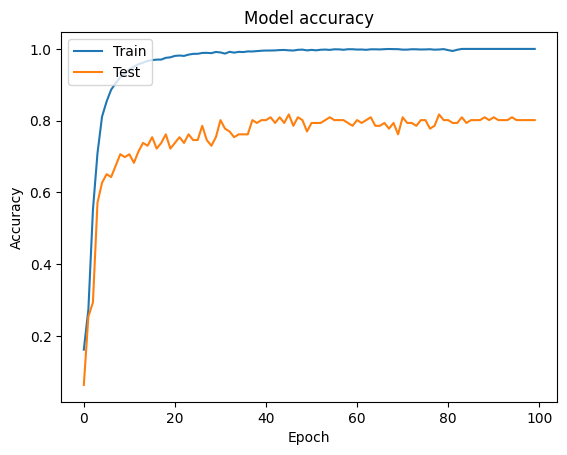

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


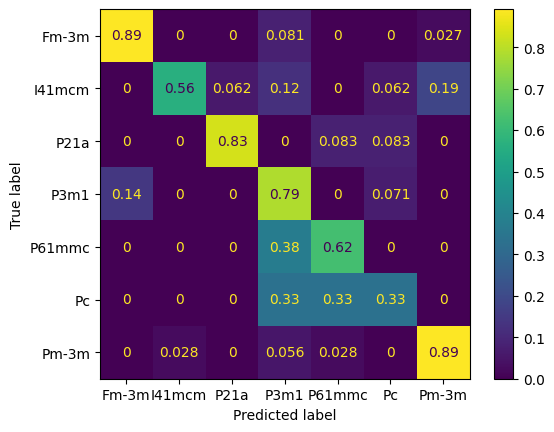

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


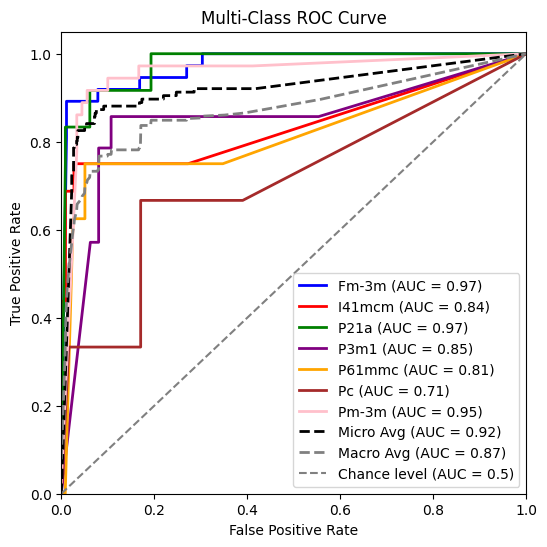

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

           0     0.9429    0.8919    0.9167        37
           1     0.9000    0.5625    0.6923        16
           2     0.9091    0.8333    0.8696        12
           3     0.5000    0.7857    0.6111        14
           4     0.6250    0.6250    0.6250         8
           5     0.2500    0.3333    0.2857         3
           6     0.8889    0.8889    0.8889        36

    accuracy                         0.8016       126
   macro avg     0.7165    0.7030    0.6985       126
weighted avg     0.8329    0.8016    0.8083       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.7915 - loss: 2.1069
{'categorical_accuracy': 0.8015872836112976, 'loss': 1.818385362625122}


In [ ]:
eval_model(layers_cnn, layers_hist, test_x, test_y)

## CNN with different num of features

In [ ]:
feat_cnn, feat_hist = a_cnn_model_features(train_x, train_y, test_x, test_y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - categorical_accuracy: 0.2242 - loss: 1.9294 - val_categorical_accuracy: 0.2063 - val_loss: 1.8078
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - categorical_accuracy: 0.4309 - loss: 1.5681 - val_categorical_accuracy: 0.2381 - val_loss: 2.2101
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.5051 - loss: 1.3107 - val_categorical_accuracy: 0.3175 - val_loss: 1.9906
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.5425 - loss: 1.2366 - val_categorical_accuracy: 0.3016 - val_loss: 2.1627
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.5625 - loss: 1.1498 - val_categorical_accuracy: 0.3810 - val_loss: 2.1192
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.5846 - loss: 1.0882 - val_categorical_accuracy: 0.3333 - val_loss: 2.1839
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.6073 - los

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 150, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 30, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,599 (424.22 KB)

 Trainable params: 36,199 (141.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 72,400 (282.82 KB)

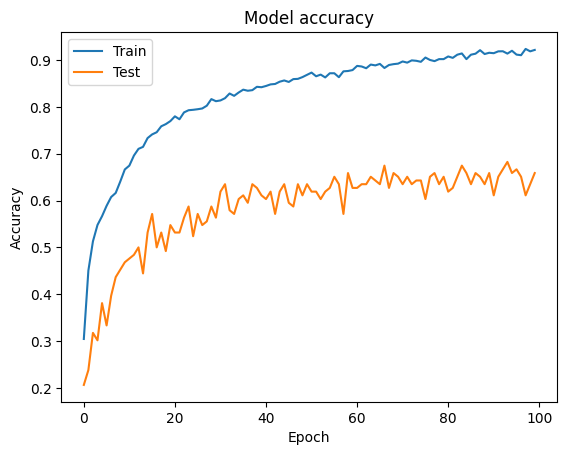

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


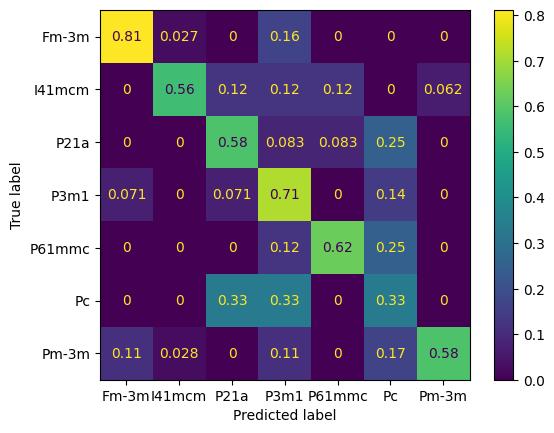

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


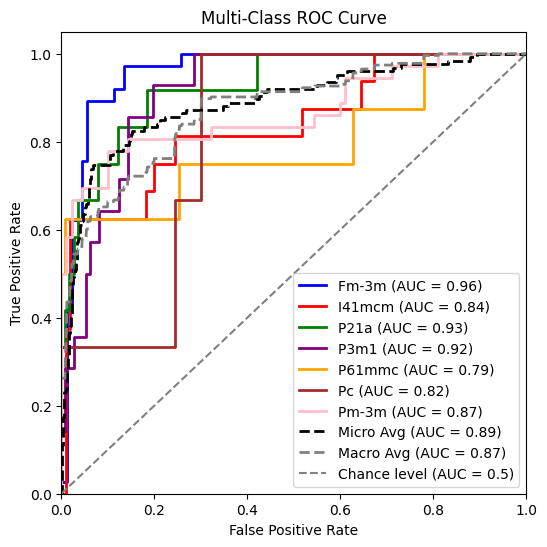

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
              precision    recall  f1-score   support

           0     0.8571    0.8108    0.8333        37
           1     0.8182    0.5625    0.6667        16
           2     0.6364    0.5833    0.6087        12
           3     0.4000    0.7143    0.5128        14
           4     0.6250    0.6250    0.6250         8
           5     0.0714    0.3333    0.1176         3
           6     0.9545    0.5833    0.7241        36

    accuracy                         0.6587       126
   macro avg     0.6232    0.6018    0.5840       126
weighted avg     0.7748    0.6587    0.6937       126

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.6354 - loss: 3.7958
{'categorical_accuracy': 0.658730149269104, 'loss': 3.338608741760254}


In [ ]:
eval_model(feat_cnn, feat_hist, test_x, test_y)

##Big model

In [ ]:
big_cnn, big_hist = cnn_model_big(train_x, train_y, test_x, test_y)

In [ ]:
eval_model(big_cnn, feat_hist, test_x, test_y)

[  2   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


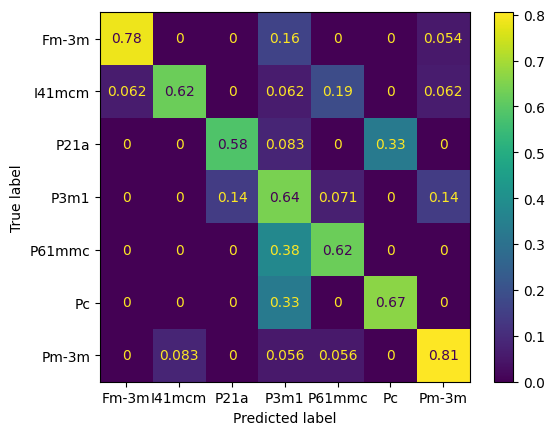

Accuracy: 0.7222222222222222


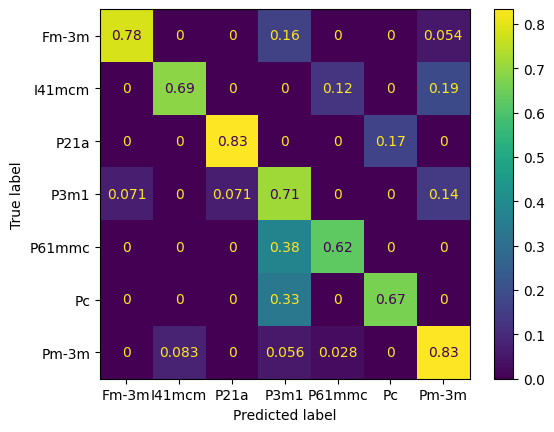

Accuracy: 0.7698412698412699


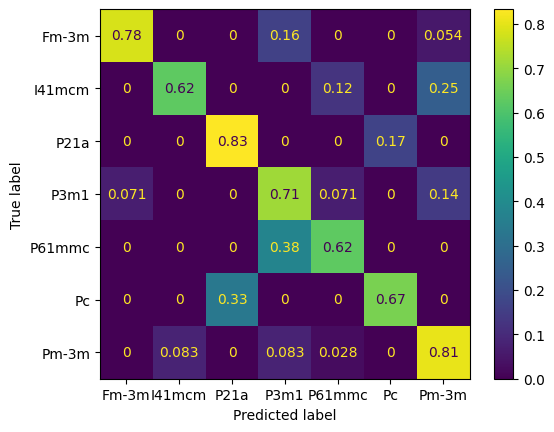

Accuracy: 0.753968253968254


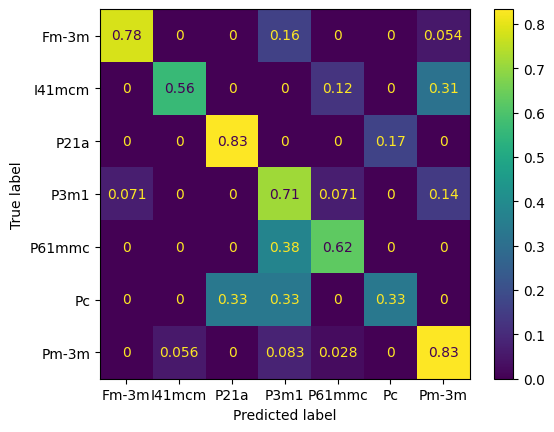

Accuracy: 0.746031746031746


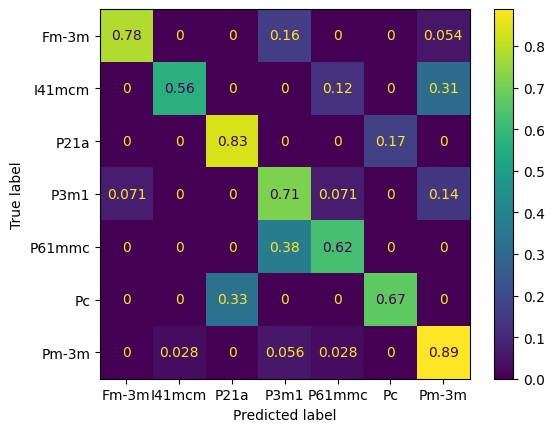

Accuracy: 0.7698412698412699


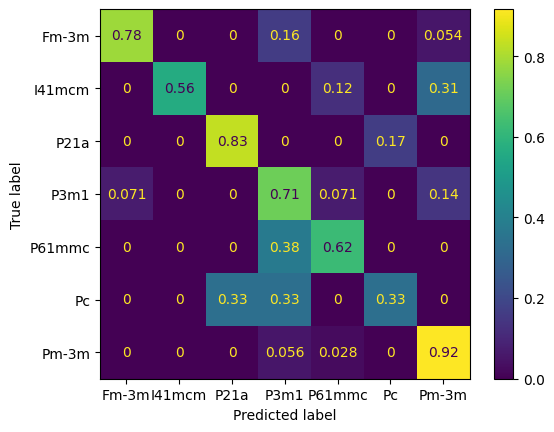

Accuracy: 0.7698412698412699


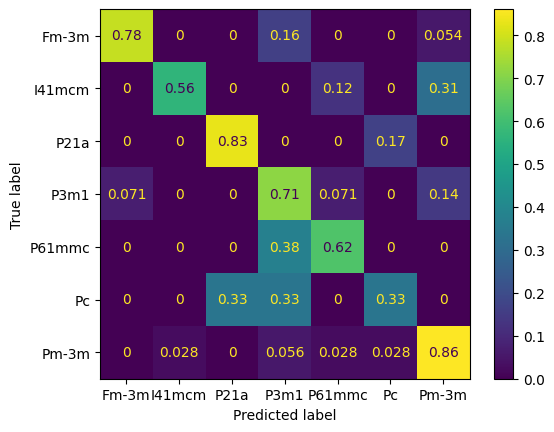

Accuracy: 0.753968253968254


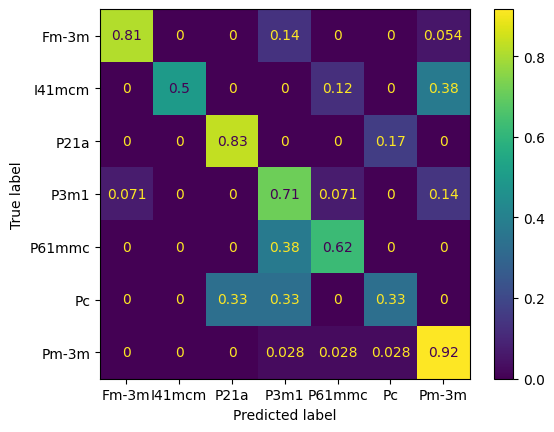

Accuracy: 0.7698412698412699


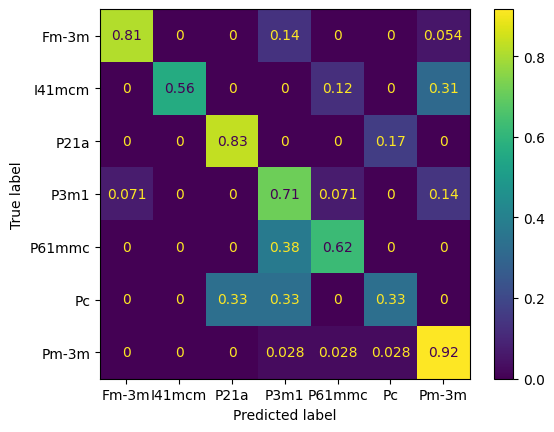

Accuracy: 0.7777777777777778


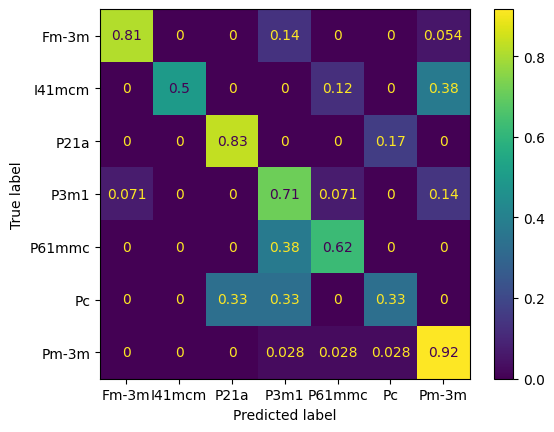

Accuracy: 0.7698412698412699


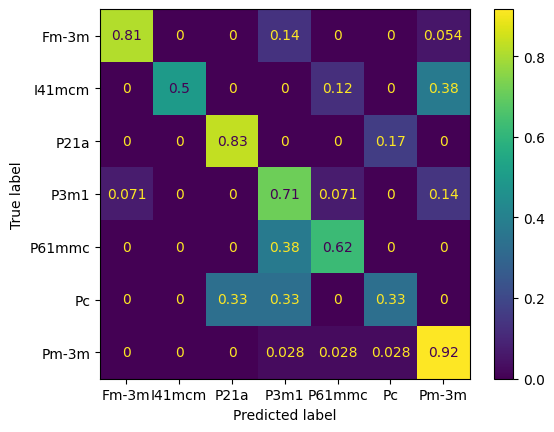

Accuracy: 0.7698412698412699


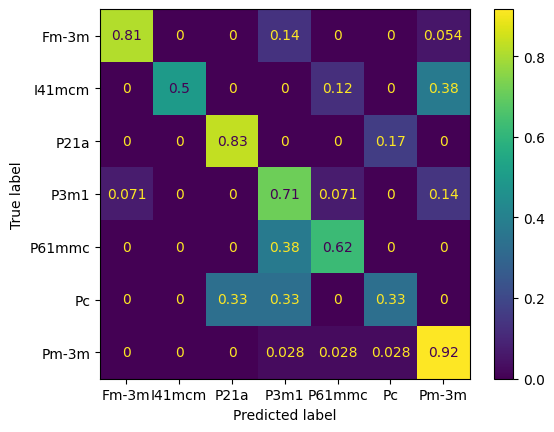

Accuracy: 0.7698412698412699


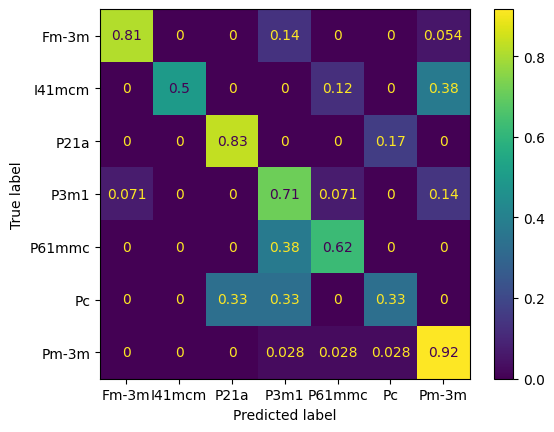

Accuracy: 0.7698412698412699


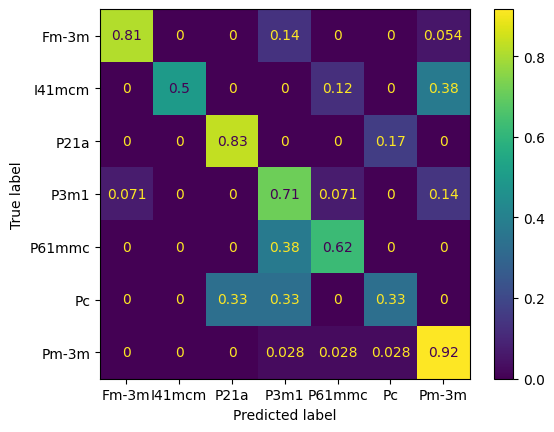

Accuracy: 0.7698412698412699


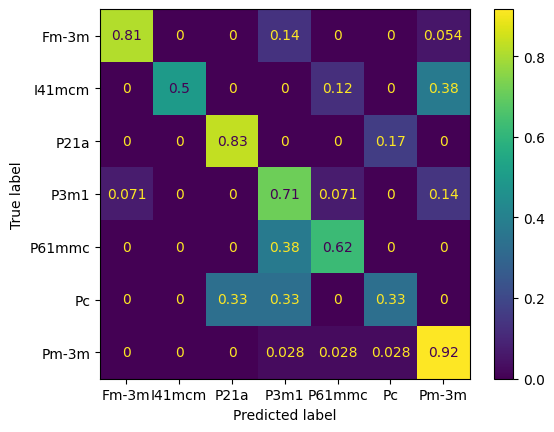

Accuracy: 0.7698412698412699


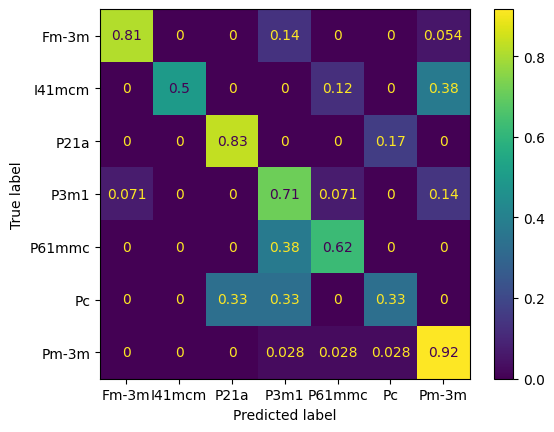

Accuracy: 0.7698412698412699


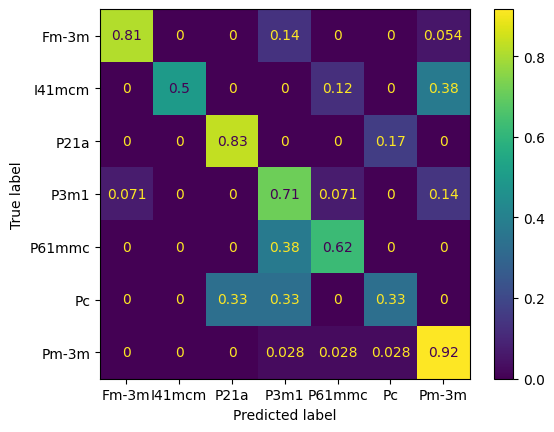

Accuracy: 0.7698412698412699


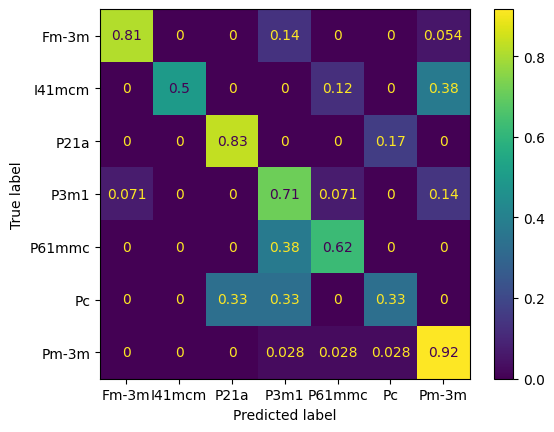

Accuracy: 0.7698412698412699


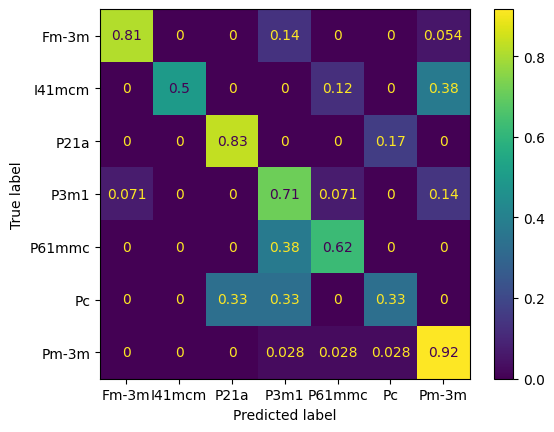

Accuracy: 0.7698412698412699


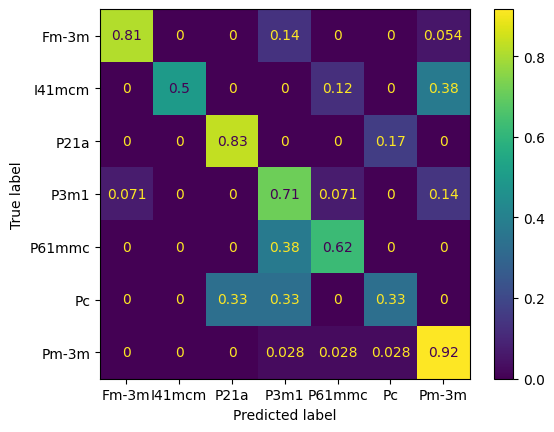

Accuracy: 0.7698412698412699


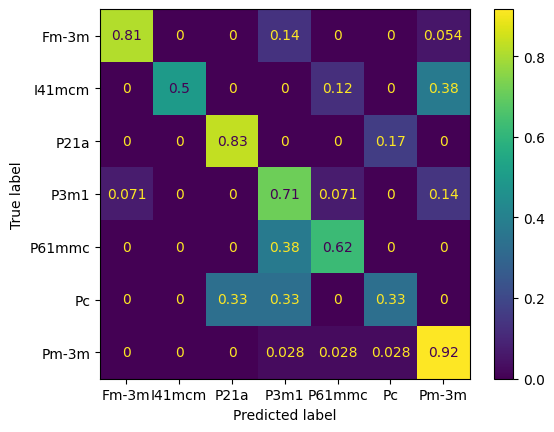

Accuracy: 0.7698412698412699


In [ ]:
from sklearn.metrics import accuracy_score

rounds=np.array([2])
rounds = np.append(rounds, np.arange(5, 101, 5))
print(rounds)
accuracies = []
#for loop to test the performance of the decision tree as a function of number of rounds
for i in rounds:
    model_tree = decision_tree(train_x, train_y, i)
    dtest = xgb.DMatrix(X_test, label=y_test)

    y_pred = model_tree.predict(dtest)

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    # cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(label_theo))
    disp.plot()
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    accuracies.append(accuracy)

score = {
    'rounds': rounds,
    'accuracy': accuracies
}

score_table = pd.DataFrame(score)

In [ ]:
plt.plot(score_table['rounds'], score_table['accuracy'])
plt.xlabel('rounds')
plt.ylabel('accuracy')
plt.show()

In [ ]:
max_index = np.argmax(accuracies)
max_value = accuracies[max_index]
max_rounds = rounds[max_index]
print(f"The maximum value is {max_value} at {max_rounds} rounds.")

# F1 Hyperparameter tunning

##Original NN

In [ ]:
def model_builder(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt')

# Perform hyperparameter search
tuner.search(train_X, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_X, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

##Batch normalization

In [ ]:
def model_builder_batch(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))
    model.add(K.layers.BatchNormalization())

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder_batch,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_batch')

# Perform hyperparameter search
tuner.search(train_X, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_X, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

##Dropout

In [ ]:
def model_builder_dropout(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 16, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    # Add Dropout after the first Conv1D layer
    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout1))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 5, strides=5, padding='same', activation='relu'))

    # Add Dropout after the second Conv1D layer (optional)
    hp_dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout2))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 3, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout3 = hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout3))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

tuner = kt.Hyperband(model_builder_dropout,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_dropout')

# Perform hyperparameter search
tuner.search(train_X, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_X, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))

##Big model

In [ ]:
def model_builder_big(hp):
    """Builds a CNN model with hyperparameters to be tuned."""
    model = Sequential()

    # Tune the number of filters in the first Conv1D layer
    hp_units1 = hp.Int('units1', min_value=32, max_value=128, step=32)
    model.add(K.layers.Conv1D(hp_units1, 150, strides=8, padding='same', input_shape=(1200, 1), activation='relu'))

    model.add(K.layers.BatchNormalization())

    # Add Dropout after the first Conv1D layer
    hp_dropout1 = hp.Float('dropout1', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout1))

    # Tune the number of filters in the second Conv1D layer
    hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units2, 30, strides=5, padding='same', activation='relu'))

    # Add Dropout after the second Conv1D layer (optional)
    hp_dropout2 = hp.Float('dropout2', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout2))

    # Tune the number of filters in the third Conv1D layer
    hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units3, 6, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout3 = hp.Float('dropout3', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout3))

    # Tune the number of filters in the third Conv1D layer
    hp_units4 = hp.Int('units4', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units4, 2, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout4 = hp.Float('dropout4', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout4))

    # Tune the number of filters in the third Conv1D layer
    hp_units5 = hp.Int('units5', min_value=16, max_value=64, step=16)
    model.add(K.layers.Conv1D(hp_units5, 1, strides=3, padding='same', activation='relu'))

    # Add Dropout after the third Conv1D layer (optional)
    hp_dropout5 = hp.Float('dropout5', min_value=0.0, max_value=0.5, step=0.1)  # Tune dropout rate
    model.add(K.layers.Dropout(hp_dropout5))

    model.add(GlobalAveragePooling1D())
    model.add(K.layers.Dense(7, activation='softmax'))  # n_classes = 7

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = K.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

tuner = kt.Hyperband(model_builder_big,
                     objective='val_categorical_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/DLP',
                     project_name='intro_to_kt_big')

# Perform hyperparameter search
tuner.search(train_X, train_y, epochs=50, validation_data=(test_x, test_y))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
hist = model.fit(train_X, train_y, batch_size=64, epochs=100,
                 verbose=1, validation_data=(test_x, test_y))